# Introduction

LightFM is a very popular tool, which finds its applications both in small projects and in production systems. Aside from the technical aspects, the general idea of representing users and items in terms of feature combinations, used in the LightFM model, is not new. It was implemented in a number of preceeding works, and I'm not even saying about the obvious link to [Factorization Machines](https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf). Another notable member of this family is [SVDFeature](https://arxiv.org/pdf/1109.2271.pdf) , which came around in 2011 and in some sense is even closer to LightFM than FM (the naming, though, is misleading, as it is not an SVD-based model). In fact, the feature combination approach can be traced back to the Microsoft's [MatchBox system](https://www.microsoft.com/en-us/research/wp-content/uploads/2009/01/www09.pdf) from 2009, where they use the term *trait vector* for a combined representation. Still, even though the idea itself was not new, the LightFM model was made convenient and extreemly easy to use and had a fairly good computational performance, which, I believe, has made this framework so popular among practitioners.

On the other hand, I have also seen some complains from data scientists about actual prediction quality of LightFM. Moreover, I could not find more or less rigorous comparison of LightFM with strong baselines, where all compared models would undergo appropriate tuning. The [examples section](https://lyst.github.io/lightfm/docs/examples.html) of the LightFM's documentation merely provides quick-start demos, not real performance tests. The [paper from the RecSys workshop](http://ceur-ws.org/Vol-1448/paper4.pdf) also does not provide too much evidence on the model's performance. Numerous online tutorials only repeat basic configuration steps, leaving aside the whole tuning aspect. Considering how often practitioners are advised to start with LightFM (according to data science chats and forums I'm aware of), I have decided **to put the LightFM capabilities to the real test**.

<div class="alert alert-block alert-info">In this tutorial we will conduct a thorough experiment with proper tuning and testing of LightFM against some strong baselines in the cold strat setting.</div>

The baseline models in this tutorial will be based on my favorite SVD (the real one, not just some matrix factorization). I have summarized the reasons why I promote SVD-based recommendation algorithms as the default choice in my [previous post](//slug:to-svd-or-not-to-svd). However, I have not yet described how to use SVD in the cold start scenario. The theoretical foundation of this can be found in our [recent paper](https://arxiv.org/abs/1802.06398), where we demonstrate how to adopt both PureSVD and HybridSVD models for the cold start scenario. Here, I will provide only the minimum necessary material for understanding what is going on, focusing more on technical aspects instead. For all experiments we will be using [Polara](https://github.com/evfro/polara), as it provides easy-to-use high-level API for both LightFM and SVD-based models, as well as a set of convenient tools for building the entire experimentation pipeline.

Unlike many online materials, we will employ an *advanced optimization procedure for LightFM* to ensure that the obtained model is close to its optimal configuration.
Conversely, as we will see, *tuning of the SVD-based models is very straightforward*. They depend on fewer hyper-parameters and also have deterministic output. The question remains, whether it is possible to outperform LightFM with these simpler models. Let's find out.

## Teleport me to:
[Getting data](#getting-data)  
[Recommender models](#recommender-models)  
>[LightFM](#LightFM)  
>[PureSVD](#PureSVD)  
>[HybridSVD](#HybridSVD)  

[Evaluation of models](#evaluation-of-models)  
[Conclusion](#conclusion)  

<a id="getting-data"></a>
# Getting data

We will use the **StackExchange** dataset provided in [one of the examples](https://lyst.github.io/lightfm/docs/examples/hybrid_crossvalidated.html) from the LightFM documentation. It consist of users who have answered certain questions. In addition to the user-answer interaction matrix, the dataset also provides additional information in the form of tags assigned to each answered question. The data-reading code below is simply copied from the documentation.

## Downloading and preprocessing data

In [1]:
import numpy as np
import pandas as pd
from lightfm.datasets import fetch_stackexchange
from polara.recommender.coldstart.data import ItemColdStartData
from polara.tools.display import print_frames # to print df's side-by-side

In [2]:
data = fetch_stackexchange('crossvalidated',
                           test_set_fraction=0.1,
                           indicator_features=False,
                           tag_features=True)

The `data` variable contains both training and test datasets, as well as tag assignments and their labels:

In [3]:
print(data.keys())

dict_keys(['train', 'test', 'item_features', 'item_feature_labels'])


Now, we need to convert it into the Polara-compatible format of `pandas DataFrames`. Mind the field names for users and items in the result:

In [4]:
entities = ['users', 'items']
training_data = pd.DataFrame(dict(zip(entities, data['train'].nonzero())))
test_data = pd.DataFrame(dict(zip(entities, data['test'].nonzero())))

In [5]:
seed = 321 # to be used in data model, LightFM, and optimization routines
training_data = training_data.sample(frac=1, random_state=seed) # shuffle data

We also need to convert item features (tags) into the dataframe with a special structure. This will enable many Polara's built-in functions for data manipulation.

In [6]:
# convert sparse matrix into `item - tag list` Series format
# make use of sparse CSR format
item_tags = (
    pd.Series(
        np.array_split(
            # convert back fron indices to tag labels
            np.take(data['item_feature_labels'],
                    data['item_features'].indices),
            # split tags into groups by items
            data['item_features'].indptr[1:-1]))
    .rename_axis('items')
    .to_frame('tags')
)

In [7]:
print_frames([training_data.head(),
              test_data.head(),
              item_tags.head()])

,users,items
35417,1088,41856
12389,205,38838
48719,2081,20186
25104,635,49982
46833,1878,30914
,users,items
0,16,70628
1,18,66569
2,18,66609
3,18,68964


## Preparing data model for training and validation

We need to wrap our data into an instance of Polara's recommender data model, which allows to share data among many recommender models and propagate consistent state across all of them. More details on its usage can be found in other [Polara examples](https://github.com/evfro/polara/tree/master/examples). In order to fine-tune models we will additionally split training data into the traininig and validation sets using the Polara's built-in functionality.

<div class="alert alert-block alert-info">Once optimal-hyperparameters are found, the model will be retrained on the full training data and verified against the initially provided test set.</div>

In [8]:
data_model = ItemColdStartData(
    training_data,
    *training_data.columns, # userid, itemid
    item_features=item_tags,
    seed=seed)
print(data_model)

ItemColdStartData with Fields(userid='users', itemid='items', feedback=None)


In [9]:
data_model.test_ratio = 0.05 # take 5% of items as cold (at random)
data_model.prepare()

Preparing data...
1 unique users entities within 2 holdout interactions were filtered. Reason: not in the training data.
Done.
There are 54975 events in the training and 2853 events in the holdout.


Let us look at the holdout data:

In [10]:
print_frames([data_model.test.holdout.head(), data_model.test.holdout.tail()])

,users,items_cold
12389,39,0
48717,1,1
25266,75,2
27901,1242,2
30278,32,3
,users,items_cold
8223,29,1920
36348,677,1921
13834,53,1922
38558,343,1923


**The procedure for both validation and final evaluation will be the following**:
1. For every unique cold item, we generate a list of candidate users who, according to our model, are most likely to be intersted in this item.
2. We then verify the list of predicted users against the actual users from the holdout.

We will use standard evaluation metrics to assess the quality of predictions.

<a id="recommender-models"></a>
# Recommender models

## LightFM

As stated in the introduction, LightFM is an efficient and convenient instrument for building hybrid recommender systems. There are, however, several downsides in its implementation (at least at the moment of writing this post).

First of all, **there is no off-the-shelf support for the warm start scenario** (e.g., for new users with several known interactions), which would allow estimating strong generalization of the algorithm rather then weak generalization that we test in the standard setup (with only known users).
Basically, there's no folding-in implementation, even though it seems to be in a high demand (see github issues [here](https://github.com/lyst/lightfm/issues/300), [here](https://github.com/lyst/lightfm/issues/322#issuecomment-401951114) or [here](https://github.com/lyst/lightfm/issues/194#issuecomment-310775451)) and it is not that difficult to implement. Likewise, there is no [session-based recommendations support](https://github.com/lyst/lightfm/issues/362) as well. The [sometimes recommended](https://github.com/lyst/lightfm/issues/347#issuecomment-407383263) `fit_partial` method is not really an answer to these problems. It is going to update both user and item embeddings and sometimes it is not what you may want. For example, fitting newly introduced users would affect latent representation of some know items as well, potentially changing recommendations for already present users without any of their actions. Such an unintended change in recommendations can be confusing for users and lead to a lower satisfaction with a recommendation service.

Another aspect, which is critical in certain situations is **the lack of determinism**. LightFM's output is deterministic only in strict conditions: single-threaded training with the fixed input that never changes (even the order of elements). In multithredaded execution the LightFM's optimization process causes racing conditions that are resolved at the hardware level, which you have no control of. This is not unique to LightFM and is shared across all matrix factorization algorithms based on naive SGD optimization.  Moreover, even tiny reorderings (e.g., when two items corresponding to a single user switch their places) may lead to [noticably different results](https://github.com/lyst/lightfm/issues/225). Even in this notebook, if you set the number of LightFM threads to 1 (see below), once you restart the notebook kernel, the results may change. The problem seems to be outside of LightFM itself, however, it demonstrates its non-deterministic nature. If your business has specific requirements on, e.g., non-regression testing, this model is not for you. Conversely, **SVD-based models are free of such issues.** This is also among the reasons why matrix factorization models like SVDFeature or FunkSVD should not be mixed with real SVD-based models.

### The model

In [11]:
from polara.recommender.coldstart.models import LightFMItemColdStart

In [12]:
num_threads = 4 # number of parallel threads used by LightFM
max_rank = 200 # the max value or latent features used in tuning

Setting the number of threads greater than 1 is not critical in our setup, as the result will fluctuate by a relatively small margin, which should not drammatically change the whole picture of the algorithm's performance. Nevertheless, you can try running in a fully deterministic setting and verify that. However, you'll have to wait a bit longer during the LightFM tuning phase due to a sequential execution.

In [13]:
def create_lightfm_model(data_model, item_features, num_threads, seed=None):
    'Prepare LightFM model and fix initial configuration.'
    model = LightFMItemColdStart(data_model, item_features=item_features)
    model.loss = 'warp'
    model.learning_schedule = 'adagrad'
    model.seed = seed
    model.fit_params['num_threads'] = num_threads
    return model

In [14]:
lfm = create_lightfm_model(data_model, item_tags, num_threads, seed)

### Tuning

As the LightFM algorithm depends on many hyper-parameters and has a stochastic nature, it presents a hard problem for optimization. We will have to give a fair bit of tuning to LightFM. There are many great tools for doing this. Two popular options are [HyperOpt](https://hyperopt.github.io/) and [Optuna](https://optuna.readthedocs.io/); both of them are great. I personally prefer the latter as it typically allows me to write a more concise code. We will be using it in this tutorial as well. If you don't have `optuna` installed you can simply run
```
pip install optuna
```
in your python environment.

Instead of performing *random search* for hyper-parameter optimization we will employ a more advanced and flexible techniqe based on *Tree-structured Parzen Estimator* (TPE). It will help to iteratively narrow-down the hyper-parameter search subspace and preemptively disregard unmpromising search regions. A bit more details along with further reading can be found in the [optuna documentation](https://optuna.readthedocs.io/en/latest/reference/samplers.html). There is also a nice comparison of different techniques in this [blog post](http://neupy.com/2016/12/17/hyperparameter_optimization_for_neural_networks.html#tree-structured-parzen-estimators-tpe).

In [15]:
import optuna
try: # import lightweight progressbar
    from ipypb import track
except ImportError: # fallback to default
    from tqdm.auto import tqdm as track

Note that tuning for all possible types of hyper-parameters exponentially increases the complexity of the task. The authors of `optuna` even recommend to refrain from tuning unimportant variables. We will therefore **concentrate on 3 main hyper-parameters**:
1. dimensionality of the latent space (rank of the factor matrices),
2. importance of item features, controlled by the `item_alpha` regularization parameter,
3. number of epochs.

We will leave other hyper-parameters with their default values. My preliminary experiments showed that there was no big difference in the final result after changing them, as long as their values remained within a reasonable range. As always, you are free verify that on your own by adding more hyper-parameters into the search space. You will need to modify the `objective` function defined below.

To aid the learning process, we will sample `item_alpha` from a log-uniform distribution and `rank` values from a range of positive integer numbers up to `max_rank`. Note that we also use `set_user_attr` routine to store additional information related to each tuning trial.

In [16]:
def evaluate_lightfm(model):
    'Convenience function for evaluating lightfm.'
    # disabling user bias terms improves cold start prediction quality
    model._model.user_biases *= 0.0
    return model.evaluate()

def find_target_metric(metrics, target_metric):
    'Convenience function to quickly extract the required metric.'
    for metric in metrics:
        if hasattr(metric, target_metric):
            return getattr(metric, target_metric)

def lightfm_objective(model, target_metric):
    'Objective function factory for optuna trials.'
    def objective(trial):
        # sample hyper-parameter values
        model.rank = trial.suggest_int('rank', 1, max_rank)
        model.item_alpha = trial.suggest_loguniform('item_alpha', 1e-10, 1e-0)
        # train model silently and evaluate
        model.verbose = False
        model.build()
        metrics = evaluate_lightfm(model)
        target = find_target_metric(metrics, target_metric)
        # store trial-specific information for later use
        trial.set_user_attr('epochs', model.fit_params['epochs'])
        trial.set_user_attr('metrics', metrics)
        return target
    return objective

One of the limitations of TPE is that it does not take into account possible dependencies between hyper-parameters. In addition to that, parameters like `rank` or `epochs` significantly influence the training time. In order to avoid spending too much time on tuning yet being able to achieve a reasonably good model, we will use a specific procedure. We take the number of `epochs` out of the main loop.
Based on that, we want to early exclude bad hyper-parameter values that lead to high enough scores solely due to high number of epochs. Hence, we start from a smaller number of epochs and increase it gradually, leaving out unpromising configurations along the way due to TPE optimization procedure. Hopefully, it won't discard potentially good search directions that will later produce good results with the higher number of epochs. Likewise, we also gradually decrease the trials budget for each subsequent number of epochs, assuming that narrower search space requires less exploration.

In [17]:
n_trials = {
# epochs: # trials
    15: 30,
    25: 25,
    50: 20,
    75: 15,
    100: 10,
    150: 5
}

We will target specifically the `Precision@10` metric and will anylize other metrics during the final evaluation.

In [18]:
target_metric = 'precision'
objective = lightfm_objective(lfm, target_metric)

study = optuna.create_study(
    direction = 'maximize',
    sampler = optuna.samplers.TPESampler(seed=seed)
)

optuna.logging.disable_default_handler() # do not report progress
for num_epochs, num_trials in track(n_trials.items()):
    lfm.fit_params['epochs'] = num_epochs
    study.optimize(objective, n_trials=num_trials, n_jobs=1, catch=None)

 [████████████████████████████████████████████████████████████] 6/6 [06:10<00:36, 61.66s/it]

Our optimal configuration can be retrieved as follows (note that it can be slightly different on your machine):

In [19]:
print(f'The best value of {target_metric}={study.best_value:0.4f} was achieved with '
      f'rank={study.best_params["rank"]} and item_alpha={study.best_params["item_alpha"]:.02e} '
      f'within {study.best_trial.user_attrs["epochs"]} epochs.')

The best value of precision=0.0344 was achieved with rank=9 and item_alpha=7.26e-07 within 100 epochs.


### Visualizing tuning results

Let's plot the result to see whether there are any trends and whether we need to continue our parameter search in some new region of the hyper-parameter subspace.

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-notebook']) # see plt.style.available

In [21]:
trials_df = (study.trials_dataframe() # all trials history
             .loc[:, ['value', 'params', 'user_attrs']]
             .rename(columns={'': target_metric}))
trials_df.columns = trials_df.columns.get_level_values(1)
trials_df.sort_values('precision').tail()

,precision,item_alpha,rank,epochs,metrics
92,0.033974,2.986615e-07,6,100,"[(0.03397402597402597, 0.25204923647780786, No..."
99,0.034078,1.901221e-06,12,100,"[(0.034077922077922075, 0.25326630512344794, N..."
53,0.034078,5.043306e-06,25,25,"[(0.034077922077922075, 0.2526167166167166, No..."
60,0.034234,3.091518e-09,9,50,"[(0.034233766233766234, 0.2541265401265401, No..."
91,0.034390,7.262623e-07,9,100,"[(0.034389610389610394, 0.2558374958374958, No..."


We will treat low-score points (likely obtained at the initial tuning stage) as outliers and only take into account the top-20% results.

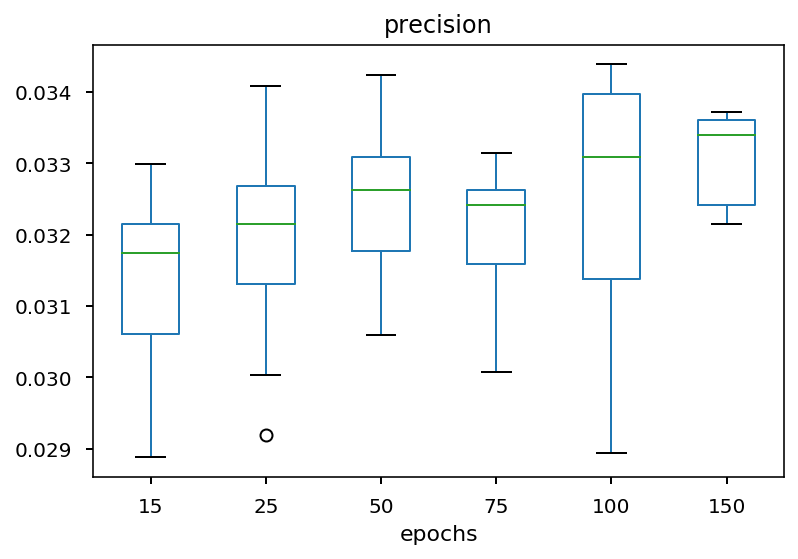

In [22]:
# take only top-20% of the points for analysis
(trials_df.query(f'{target_metric}>{0.8*study.best_value}')
          .boxplot(column=target_metric, by='epochs', grid=False))
plt.suptitle(''); # hide auto-generated box-plot title

Even though this plot is not suitable for making conclusions about the *actual perfromance* of the LightFM model, it roughly indicates that, *with the current selection of optimization mechanism*, **increasing the number of epochs further is unlikely to significantly improve the quality of predictions**. In other words, our tuning procedure reached a nearly stable state and, most likely, it is somewhere close to a local optimum. We will, therefore, proceed with the best found configuration without any further adjustments. Below is a characterizing plot of all trials.

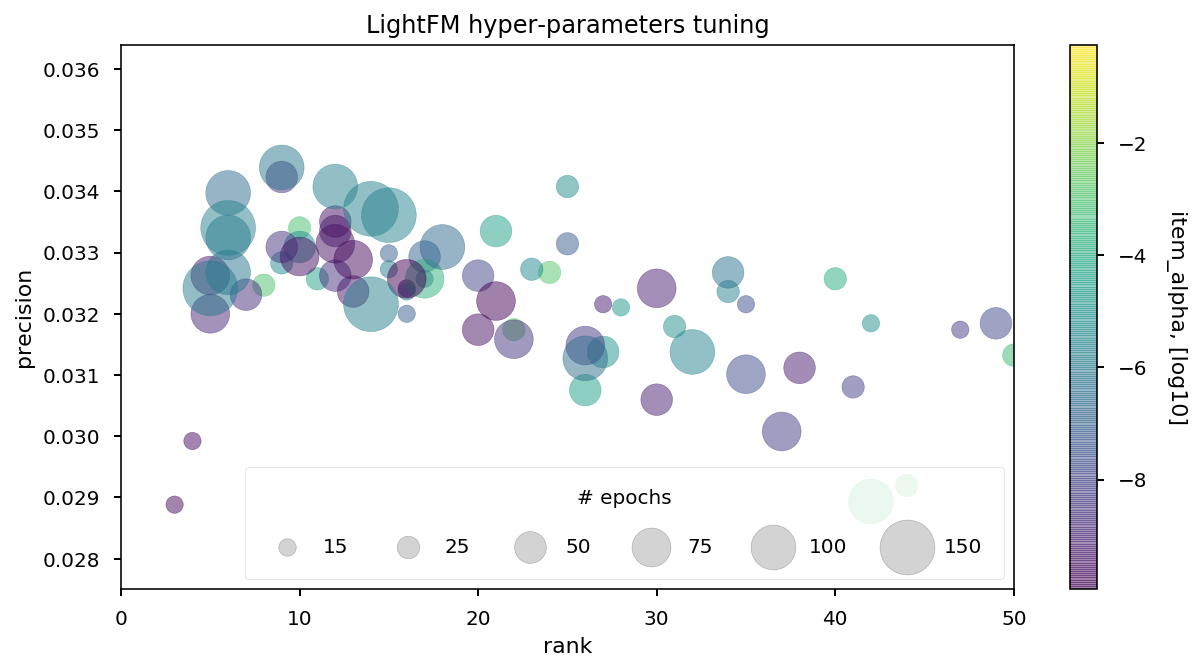

In [23]:
plt.figure(figsize=(10, 5))
# limit plot display region
plt.xlim(0, 50)
plt.ylim(0.8*study.best_value, study.best_value + 0.002)
# plot points
marker_scale = 5
sc = plt.scatter(
    trials_df['rank'], trials_df[target_metric],
    # circle size indicates the number of epochs 
    s=trials_df['epochs']*marker_scale,
    # color encodes the value of item_alpha (logscale)
    c=np.log10(trials_df['item_alpha']),
    alpha=0.5, cmap="viridis", marker='o'
)
# prepare legend handles for each number of epochs
legend_labels = n_trials.keys()
legend_handles = [
    plt.scatter([], [], s=n_epochs*marker_scale, marker='o',
                color='lightgrey', edgecolors='darkgrey')
    for n_epochs in legend_labels
]
# add legend, ensuring 1:1 scale with the main plot
plt.legend(
    legend_handles, legend_labels,
    scatterpoints=1, ncol=len(legend_labels),
    title='# epochs', borderpad=1.1,
    labelspacing=1.5, markerscale=1,
    loc='lower right'
)    
# add colorbar for item_alpha values
clb = plt.colorbar(sc)
clb.set_label('item_alpha, [log10]', rotation=-90, labelpad=20)
# annotate plot
plt.title('LightFM hyper-parameters tuning')
plt.xlabel('rank')
plt.ylabel(target_metric);

We see that even lower values of the number of epochs produce a relatively good score, whcih also supports the assumption that we have probably found nearly optimal values. **How good is this result?** To answer that question we need to introduce the baselines.  

## PureSVD

This will be our first baseline. We will simply reuse the scaled version of PureSVD which has shown to perform very competitively with other models. For more details, see the  "[Reproducing EIGENREC results](https://github.com/evfro/polara/blob/master/examples/Reproducing_EIGENREC_results.ipynb)" tutorial. The only difference is that the model is additionally adopted for the cold start evaluation scenario. In this modification the latent representation $v$ of a cold item can be obtained by solving the following linear system:
$$
W^\top v = f,
$$
where $f$ is a one-hot vector of real item features (tags in our case), and $W=V^\top F$ is a precomputed linear mapping between the learned latent space represented by the right singular vectors $V$ and the feature matrix $F$ (the one-hot encoding of tags for known items). Everything here can be calculated efficiently. For more details I invite you to check [our paper](https://arxiv.org/abs/1802.06398). After you find the latent representation of a cold item, you can utilize the standard notion of a scalar product to find relevant users. 

### The model

In [24]:
from polara.recommender.coldstart.models import ScaledSVDItemColdStart

In the cold start scenario the model depends on side features (needed to construct the matrix $F$). This informaion can be provided via an input argument during instantiation of the model itself. An alternative and more robust way used here is to provide features in the data model constructor. Hence, the required `item_tags` variable  will be taken from the `data_model` object.

In [25]:
svd = ScaledSVDItemColdStart(data_model)

### Tuning

Computing and evaluating SVD is going to be blazingly fast as the dataset is small and the model is computed only once for every scaling value due to a simple rank truncation procedure. Hence, we can create a very dense parameter grid, which can still be greedily explored with the grid-search in a reasonable amount of time.

In [26]:
from polara.evaluation.pipelines import find_optimal_config # generic routine for grid-search

In [27]:
def fine_tune_scaledsvd(model, ranks, scale_params, target_metric):
    'Efficiently tuning SVD rank for different scaling parameter values.'
    # descending order helps avoiding model recomputation
    rev_ranks = sorted(ranks, key=lambda x: -x)
    param_grid = [(s, r) for s in scale_params for r in rev_ranks]
    param_names = ('col_scaling', 'rank')
    config, scores = find_optimal_config(
        model, param_grid, param_names, target_metric,
        return_scores=True, force_build=False, iterator=track
    )
    return config, scores

In [28]:
# define the hyper-parameters grid
rank_grid = [1,] + list(range(5, max_rank+1, 5)) # 1, 5, 10, ..., max_rank
scaling_grid = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8] # 1.0 is for PureSVD

In [29]:
# perform tuning
svd_best_config, svd_scores = fine_tune_scaledsvd(
    svd, rank_grid, scaling_grid, target_metric
)

 [████████████████████████████████████████████████████████████] 369/369 [01:06<00:00, 0.18s/it]

In [30]:
print(f'The best value of {target_metric}={svd_scores.max():.4f} was achieved with '
      f'rank={svd_best_config["rank"]} and scaling parameter={svd_best_config["col_scaling"]}.')

The best value of precision=0.0298 was achieved with rank=45 and scaling parameter=0.6.


Recall, the result is fully deterministic and reproducible in this case.

### Visualizing tuning results

The resulting hyper-parameter search grid can be conveniently represented as a heatmap:

In [31]:
(svd_scores.sort_index()
           .unstack(level='col_scaling')
           .iloc[::3] # don't display all rank values
           .style
           .format("{:.4f}")
           .background_gradient(cmap='viridis', high=0.2, axis=None))

col_scaling,-0.8,-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8
rank,,,,,,,,,
1,0.0224,0.0231,0.0231,0.0231,0.0231,0.0231,0.0231,0.0231,0.0231
15,0.0255,0.0253,0.0257,0.0261,0.0259,0.0259,0.0260,0.0263,0.0269
30,0.0266,0.0267,0.0269,0.0268,0.0270,0.0268,0.0282,0.0282,0.0275
45,0.0294,0.0289,0.0290,0.0290,0.0291,0.0290,0.0290,0.0298,0.0288
60,0.0286,0.0286,0.0287,0.0289,0.0289,0.0292,0.0286,0.0285,0.0287
75,0.0279,0.0279,0.0281,0.0283,0.0285,0.0287,0.0286,0.0286,0.0291
90,0.0279,0.0276,0.0276,0.0277,0.0278,0.0282,0.0279,0.0283,0.0285
105,0.0279,0.0279,0.0284,0.0282,0.0284,0.0283,0.0285,0.0287,0.0286
120,0.0279,0.0279,0.0276,0.0276,0.0281,0.0282,0.0282,0.0281,0.0282


As we can see, the optimal rank values sit somewhere around the rank 50. The prediction quality is not impressive, though. Surprisingly, unlike [many other examples](https://arxiv.org/abs/1802.06398), this time the scaling does not help too much and the model performs poorly. It may indicate that properly handling side information plays more critical role than data debiasing. Seemingly, *SVD is unable to reliably connect tag-based description with the latent representation*. **We can try to fix this problem with the help of the hybrid version of SVD**. This is going to be the second and the main baseline. 

## HybridSVD

<div class="alert alert-block alert-info">HybridSVD allows to impose the desired structure on the latent feature space using side information.</div> 

Hopefully, this structure will be more appropriate for discovering relationships between the real and the latent features, and will improve predictions quality in the cold start. The hybrid functionality of SVD is enabled by the use of additional information about similarities between users and/or items. These similarities are computed beforehand and utilize side features (item tags in our case). The **model still uses SVD for computations**, even though internally it is applied to a special auxiliary matrix instead of the original one. It, therefore, remains the "real" SVD-based model **with all its advantages**. Once again, you can look up the details in [our paper](https://arxiv.org/abs/1802.06398). The process of computing the model and generating recommendations remains largely the same, except for the additional handling of similarity information. Polara already provides support for this. We only need to invoke the necessary methods and classes. See the related data pre-processing procedure below. 

### Preparing similarity data

We start by computing the tag-based similarity between items using the Polara's built-in functions. You can use your own favorite methods to compute similarities, there is a lot of freedom here.

In [32]:
from polara.recommender.coldstart.data import ItemColdStartSimilarityData
from polara.lib.similarity import combine_similarity_data

In [33]:
training_tags = item_tags.reindex(training_data['items'].unique(), fill_value=[])
tag_similarity = combine_similarity_data(training_tags, similarity_type='cosine')
print('Similarity matrix density is '
      f'{tag_similarity.nnz / np.prod(tag_similarity.shape):.1%}.')

Similarity matrix density is 8.4%.


This similairty matrix will be feed into the special data model instance, which will take care of providing a consistent on-demand access to similarity information for all dependent recommender models. The input should be in the format of a dictionary, specifiyng types of entities, similarities between them and the corresponding indexing information to decode rows (or columns) of the similarity matrices:

In [34]:
similarities = {'users': None, # we have no user features
                'items': tag_similarity}
sim_indices = {'users': None,
               'items': training_tags.index}

All other functionality remains the same as in the standard data model:

In [35]:
data_model_sim = ItemColdStartSimilarityData(
    training_data,
    *training_data.columns,
    relations_matrices=similarities, # new input args
    relations_indices=sim_indices, # new input args
    item_features=item_tags,
    seed=seed
)
print(data_model_sim)

ItemColdStartSimilarityData with Fields(userid='users', itemid='items', feedback=None)


We also use the the same configuration of the new data model to ensure the same data pre-processing and the same overall setup.

In [36]:
data_model_sim.test_ratio = data_model.test_ratio
data_model_sim.prepare()

Preparing data...
1 unique users entities within 2 holdout interactions were filtered. Reason: not in the training data.
Done.
There are 54975 events in the training and 2853 events in the holdout.


### The model

In order to generate the latent representation of a cold item the model uses the same linear system as in the standard PureSVD case. The main difference is how the linear transformatin matrix $W$ is computed:
$$
W=V^\top SF,
$$
where $S$ is an item similarity matrix and $V$ is now $S$-orthogonal, e.g., $V^\top S V = I$. The model also introduces an additional weighting hyper-parameter $\alpha \in [0, 1]$:
$$
S=(1-\alpha)I + \alpha Z,
$$
where $Z$ is the actual similarity matrix computed above (see `similarities` variable). Higher values of $\alpha$ will make the model more sensitive to side information, while setting $\alpha=0$ will turn the model back into `PureSVD`. To simplify the process, we will not tune its value. We will just make it relatively high to emphasize the importance of tag information for the model. This is going to help us **verify an assumption that tag information is critical for building an adequate latent representation with SVD**.

In [37]:
from polara.recommender.coldstart.models import ScaledHybridSVDItemColdStart

In [38]:
hsvd = ScaledHybridSVDItemColdStart(data_model_sim)
hsvd.features_weight = 0.9 # the value of alpha

On the technical side, the model takes as an input the product of several sparse matrices, which forms an auxiliary matrix. As these computations are based on matrix-vector products (due to the Lanczos procedure used in the truncated SVD), we are presented with the choice:
* we can either avoid explicitly forming the auxiliary matrix and just consequently compute matrix-vector products with all involved components, or
* we can precompute and store the auxiliary matrix first and then perform a single matrix-vector multiplication.

Computational efficiency of the aforementioned approaches strongly depends on the sparsity structure of the input matrices. Therefore, the optimal choice should be decided case by case. There is a special attribute to control this behavior in the `HybridSVD` model:

In [39]:
hsvd.precompute_auxiliary_matrix = True # faster in this case

### Tuning

We have already spent some time tuning `PureSVD`. Assuming that the main contribution of `HybridSVD` is related to tag handling, we can simply reuse the the scaling values obtained earlier.
The only parameter left for tuning is the rank of decomposition. Conveniently, it **requires computing the model only once!** We can use the Polara's built-in `find_optimal_svd_rank` routine for that.

<div class="alert alert-block alert-warning">Note that some calculations with the tag similarity matrix may eat up to 10Gb of RAM due to its relatively high density.</div>

In [40]:
from polara.evaluation.pipelines import find_optimal_svd_rank

In [41]:
hsvd.col_scaling = svd_best_config['col_scaling'] # reuse PureSVD config
# perform rank tuning (will compute the model only once for the max_rank value)
hsvd_best_rank, hsvd_rank_scores = find_optimal_svd_rank(
    hsvd, rank_grid, target_metric, return_scores=True, iterator=track
)
# restore item features embeddings with the maximal rank value
hsvd.update_item_features_transform()

Updating items relations matrix


 [████████████████████████████████████████████████████████████] 41/41 [00:08<00:00, 0.20s/it]

In [42]:
print(f'The best {target_metric}={hsvd_rank_scores.loc[hsvd_best_rank]:.4f} '
      f'is achieved at rank={hsvd_best_rank}')

The best precision=0.0458 is achieved at rank=135


The result is much better than for PureSVD! Let us compare all three models together.

### Comparing tuning results for all models

Note that this is still a preliminary result, awaiting for the confirmation on the test data, provided later in this tutorial.

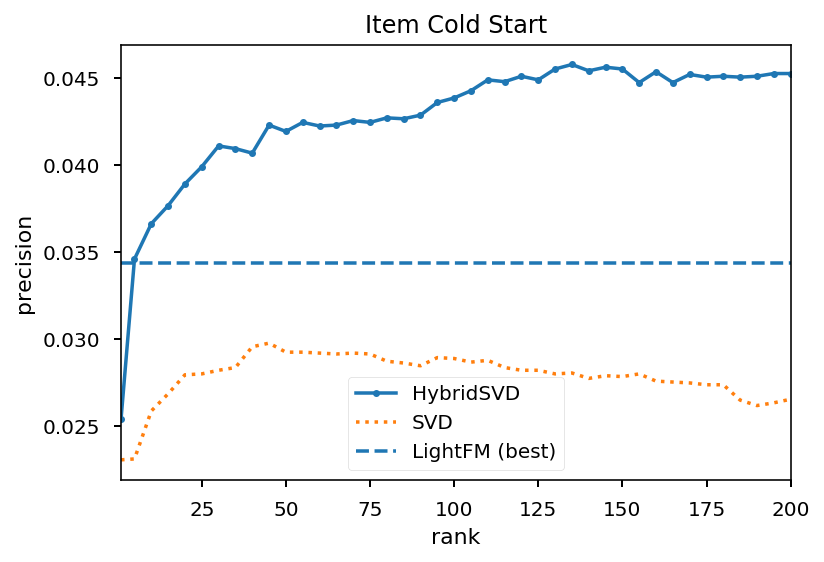

In [43]:
ax = hsvd_rank_scores.sort_index().plot(label='HybridSVD', marker='.')
svd_scores.groupby('rank').max().plot(ax=ax , label='SVD', ls=':')
ax.axhline(study.best_value, label='LightFM (best)', ls='--')
ax.legend()
ax.set_ylabel('precision')
ax.set_title('Item Cold Start');

The result demonstrates that HybridSVD is very capable and has a high potential to significantly outperform all other models. It seems that the quality of HybridSVD can be further improved with higher rank values. There is also some room for improvement in careful tuning of the scaling parameter and the weighting coefficient $\alpha$. 

<div class="alert alert-block alert-success">Interestingly, you can achieve the LightFM's quality with HybridSVD of rank 10, while the standard SVD-based model is unable to get even close to LightFM at any rank value!</div>

Here is a quick check:

In [44]:
hsvd.rank = 10 # Polara automatically truncates latent factors in SVD-based models
print(f'HybridSVD\'s {target_metric} at rank {hsvd.rank} is '
      f'{find_target_metric(hsvd.evaluate(), target_metric):.4f}\n'
      f'LightFM\'s best {target_metric} score is {study.best_value:.4f}')

HybridSVD's precision at rank 10 is 0.0366
LightFM's best precision score is 0.0344


It is time to finally verify the obtained result on the test data.

<a id="evaluation-of-models"></a>
# Evaluation of models

## Preparing data

In order to disable the Polara's built-in data splitting mechanism, we will employ two handy methods `prepare_training_only` and `set_test_data`. The former will instruct the `data_model` to utilize the whole training data for training without splitting it, and the latter will inject the test data, ensuring its overall consistency. 

In [45]:
data_model_sim.prepare_training_only()
data_model_sim.set_test_data(holdout=test_data)

Preparing data...
Done.
There are 57830 events in the training and 0 events in the holdout.
Done. There are 4307 events in the holdout.


Note that in the data splitting provided by the `fetch_stackexchange` function some of the items belong to both the training and the test set. We will ignore it and **treat all items in the testset as cold items**. Recall that in our evaluation setup we generate a list of candidate users for every cold item and than verify the list against the actual interactions present in the holdout.

## Preparing the models to compare

We need to ensure that all models use the same data to avoid any accidental discrepancies in the testing procedure. After that we train the models once again with the values of hyper-parameters, found during the tuning phase, and report the final results. 

### LightFM

In [46]:
lfm = create_lightfm_model(data_model_sim, item_tags, num_threads, seed)
lfm.rank = study.best_params['rank']
lfm.item_alpha = study.best_params['item_alpha']
lfm.fit_params['epochs'] = study.best_trial.user_attrs['epochs']
lfm.build()

LightFM training time: 4.090s


### SVD

In [47]:
svd = ScaledSVDItemColdStart(data_model_sim)
svd.col_scaling = svd_best_config['col_scaling']
svd.rank = svd_best_config['rank']
svd.build()

PureSVD(cs)-s training time: 0.112s


### HybridSVD

In [48]:
hsvd.rank = hsvd_best_rank
hsvd.build()

Updating items relations matrix
Performing sparse Cholesky decomposition for items similarity
Cholesky decomposition computation time: 01m:47s
HybridSVD(cs)-s training time: 52.765s
Building items projector for HybridSVD(cs)-s
    Solving triangular system: 1.852s
    Applying Cholesky factor: 48.022s


## Analyzing the results

Let us first gather all the scores into a single dataframe, which is convenient to anaylise.

In [49]:
from polara.evaluation.evaluation_engine import consolidate_metrics

In [50]:
all_scores = {}
all_scores['SVD (best)'] = svd.evaluate()
all_scores['LightFM (best)'] = evaluate_lightfm(lfm)
all_scores[f'HybridSVD (rank {hsvd.rank})'] = hsvd.evaluate()

In [51]:
all_scores_df = pd.concat([consolidate_metrics(scores, model, False)
                           for model, scores in all_scores.items()])

During the tuning phase we focused on the `precision` metric. It is now time to also see other metrics as well, and particularly the `coverage` score. It is calculated as the ratio of all unique recommendations, generated by an algorithms, to all unique entities of the same type present in the training data. Obviously, the maximum value is 1 (100% coverage) and it can be typically only achieved with randomly generated recommendations. The `coverage` metric characterizes the tendency of an algorithm to generate the same recommendations over and over again and is, therefore, linked to the diversity of recommendations. Higher diversity allows mitigating the famous ["Harry Potter" problem](https://www.quora.com/Recommendation-Systems-What-exactly-is-Harry-Potter-Problem), sometimes also called the "bananas problem". I personally like the term "[tyranny of the majority](https://medium.com/rtl-tech/my-takeaways-from-netflixs-personalization-workshop-2018-f564a19437b6)". More diverse recommendations are likely to improve an overall user experience as long as the relevance of recommendations remains relatively high. It may also [increase overall product sales](https://en.wikipedia.org/wiki/The_Long_Tail_(book)). However, in practice, there is an inverse relationship between diversity and accuracy of recommendations: increasing one of them may [decrease the other](https://dl.acm.org/citation.cfm?id=2043957). The underlying phenomena is the [succeptibility of many recommendation algorithms to popularity biases](https://dl.acm.org/citation.cfm?id=2852083) in the *long tail-distributed* data. We have already tried to partially address that problem by introducing the scaling parameter for SVD. Note that SGD-based algotihms like LightFM also have some control over it via different sampling schemes and customized optimization objectives.

In [52]:
(all_scores_df
 .dropna(axis=1) # skip irrelevant metrics
 .loc[:, :'coverage']
 .style.bar(subset=[target_metric, 'coverage'], color='#5fba7d', align='mid')
)

,precision,recall,miss_rate,nDCG,coverage
SVD (best),0.0228118,0.19749,0.80251,0.130738,0.016765
LightFM (best),0.0322757,0.285704,0.714296,0.20512,0.190934
HybridSVD (rank 135),0.0374726,0.328895,0.671105,0.237991,0.104315


As indicated by the green horizontal bars in the table above, standard SVD-based model performs poorly both in terms of recommendations accuracy and in terms of diversity. Likewise, LightFM presents a trade-off between these two metrics. 
However, we have seen that HybridSVD has not yet reached it's best performance. Note that **lower rank values make SVD-based models insensitive to frequent variations in the observed user behavior**, hence leading to a lower diversity of recommendations in the end. Let us try to increase the rank of the decompostition to verify that.

In [53]:
hsvd.rank = 400
hsvd.build()

HybridSVD(cs)-s training time: 02m:42s
Building items projector for HybridSVD(cs)-s
    Solving triangular system: 7.070s
    Applying Cholesky factor: 02m:28s


In [54]:
# add new HybridSVD scores to the evaluation results
all_scores_df.loc[f'HybridSVD (rank {hsvd.rank})', :] = [
    score for metrics in hsvd.evaluate() for score in metrics
]

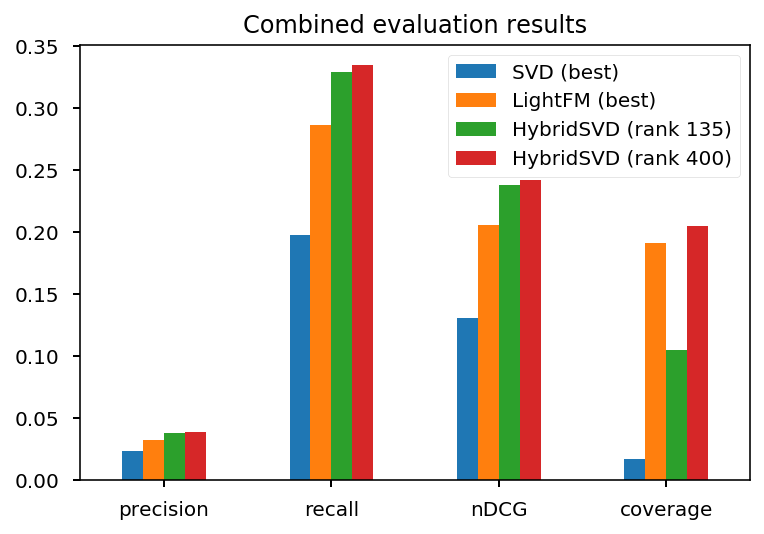

In [55]:
all_scores_df[['precision', 'recall', 'nDCG', 'coverage']].T.plot.bar(rot=0);
plt.title('Combined evaluation results');

<div class="alert alert-block alert-success">Remarkably, with HybridSVD we were able to substantially increase the diversity of recommendations without spoiling them.</div>

In fact, we have even slightly *increased the accuracy* both in terms of relevance of recommendations (indicated by precision and recall) and in terms of ranking (indicated by nDCG metric)!

<a id="conclusion"></a>
# Conclusion

This tutorial demonstrates capabilities of the HybridSVD model. Surprisingly, among many datasets I used for the [HybridSVD paper](https://arxiv.org/abs/1802.06398) none of them had such a strong dependence on side information, and HybridSVD was often only slightly better than SVD. Here we observe a different picture where standard SVD almost fails and HybridSVD actually extracts useful information, significantly outperforming its competitors. It would be interesting to know whether there are other datasets like that. If you find this tutorial helpful and will use it on another data (or with other models), let me know about your results! Do you observe the same behavior?

Of course, it does not immediately follow from this tutorial that HybridSVD will always be better than any other hybrid model, including LightFM. However, HybridSVD at least presents an easy-to-tune yet very competitive baseline. It inherits the main advantages of the standard PureSVD approach and extends its functionality. Moreover, its hyper-parameters have a straightforward and intuitive effect on the quality of recommendations.

There are certain technical challenges, related to implementation of the algorithm, which I'm not going to discuss here (the post is already too long). Some of them will be addressed in forthcoming papers. However, if you have any specific question in mind, let me know in the comments section below or post an issue in the Polara's github repository.